# *Imports & Configuration*

In [1]:
import os
from pathlib import Path
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from PIL import Image
import cv2


In [2]:
DATASET_ROOT = "/kaggle/input/plantvillage-dataset"

DATA_VARIANTS = {
    "color": "color",
    "grayscale": "grayscale",
    "segmented": "segmented",
}

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


# *Unified Image Indexing*

In [3]:
def build_image_index(root, variants):
    records = []

    for variant, folder in variants.items():
        base = Path(root) / folder

        for path in base.rglob("*.*"):
            if path.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
                continue

            records.append({
                "variant": variant,
                "Class": path.parts[-2],
                "image_name": path.name,
                "path": str(path)
            })

    return pd.DataFrame(records)

image_index = build_image_index(DATASET_ROOT, DATA_VARIANTS)
image_index.head()


,variant,Class,image_name,path
0,color,Tomato___Late_blight,781e93a9-2059-42de-8075-658033a6abf7___RS_Late...,/kaggle/input/plantvillage-dataset/color/Tomat...
1,color,Tomato___Late_blight,283ff0be-6e5e-4b4e-bf21-639780b77ffc___GHLB2 L...,/kaggle/input/plantvillage-dataset/color/Tomat...
2,color,Tomato___Late_blight,0db85707-41f9-42df-ba3b-842d14f00a68___GHLB2 L...,/kaggle/input/plantvillage-dataset/color/Tomat...
3,color,Tomato___Late_blight,078a999d-6e6f-427e-a1e6-80b4d2df2bae___GHLB2 L...,/kaggle/input/plantvillage-dataset/color/Tomat...
4,color,Tomato___Late_blight,3dcee9ed-43bb-45a9-8cff-641b3dd62179___RS_Late...,/kaggle/input/plantvillage-dataset/color/Tomat...


# *Dataset-Level Summary (All Variants)*

In [4]:
eda_results = {}

for variant in DATA_VARIANTS.keys():
    df = image_index[image_index["variant"] == variant]

    print(f"\n========== {variant.upper()} DATASET ==========")
    print("Total Images:", len(df))
    print("Total Classes:", df["Class"].nunique())

    pd.set_option("display.max_rows", None)
    print(df["Class"].value_counts())
    pd.reset_option("display.max_rows")

    eda_results[variant] = {
        "df": df,
        "class_distribution": df["Class"].value_counts()
    }



========== COLOR DATASET ==========
Total Images: 54305
Total Classes: 38
Class
Orange___Haunglongbing_(Citrus_greening)              5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus                5357
Soybean___healthy                                     5090
Peach___Bacterial_spot                                2297
Tomato___Bacterial_spot                               2127
Tomato___Late_blight                                  1909
Squash___Powdery_mildew                               1835
Tomato___Septoria_leaf_spot                           1771
Tomato___Spider_mites Two-spotted_spider_mite         1676
Apple___healthy                                       1645
Tomato___healthy                                      1591
Blueberry___healthy                                   1502
Pepper,_bell___healthy                                1478
Tomato___Target_Spot                                  1404
Grape___Esca_(Black_Measles)                          1383
Corn_(maize)___Common_rust_       

# *Class Imbalance Visualization*

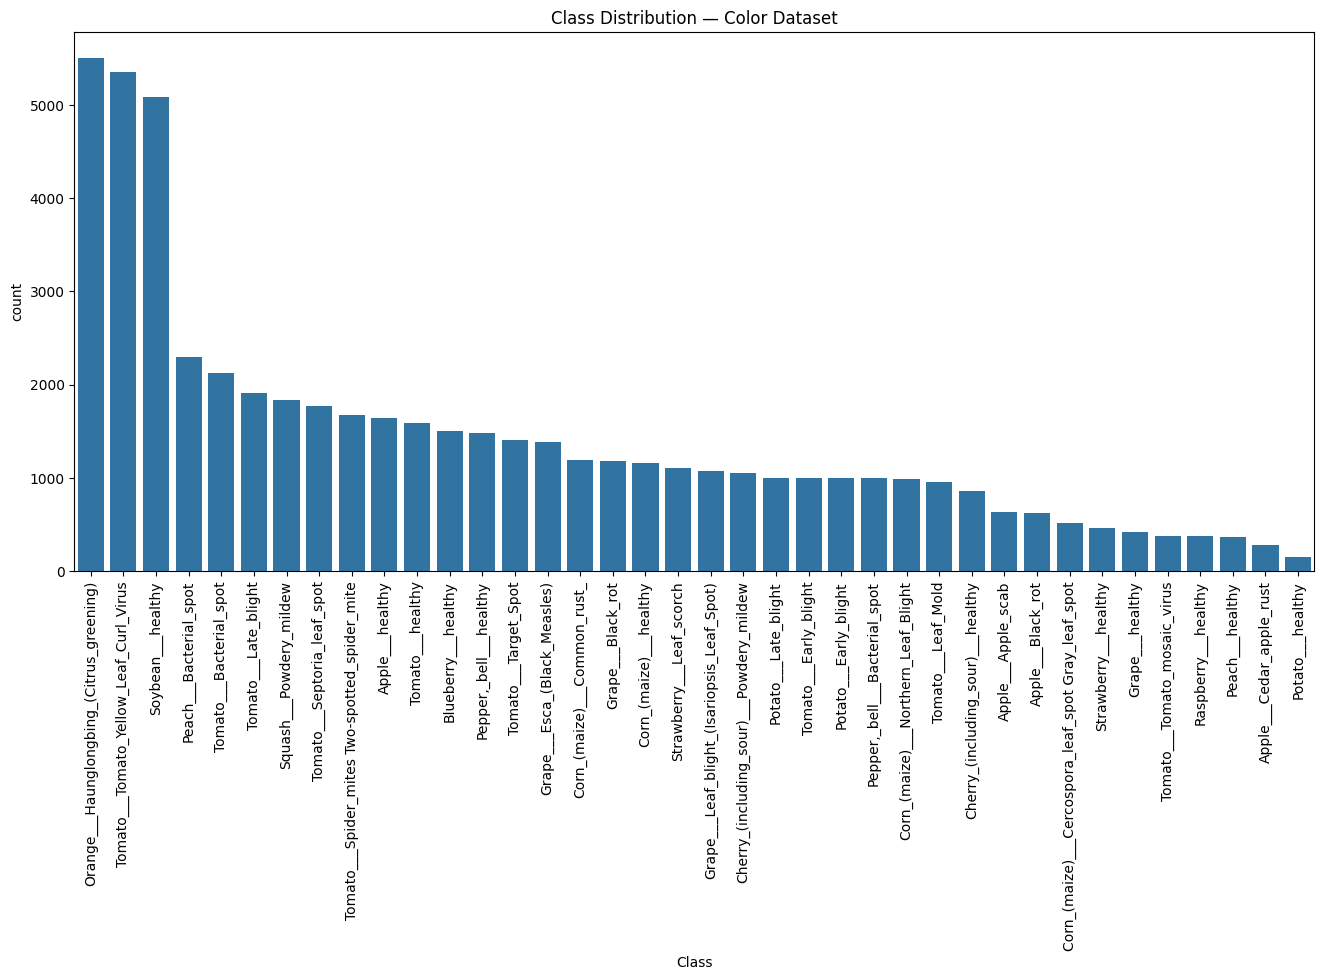

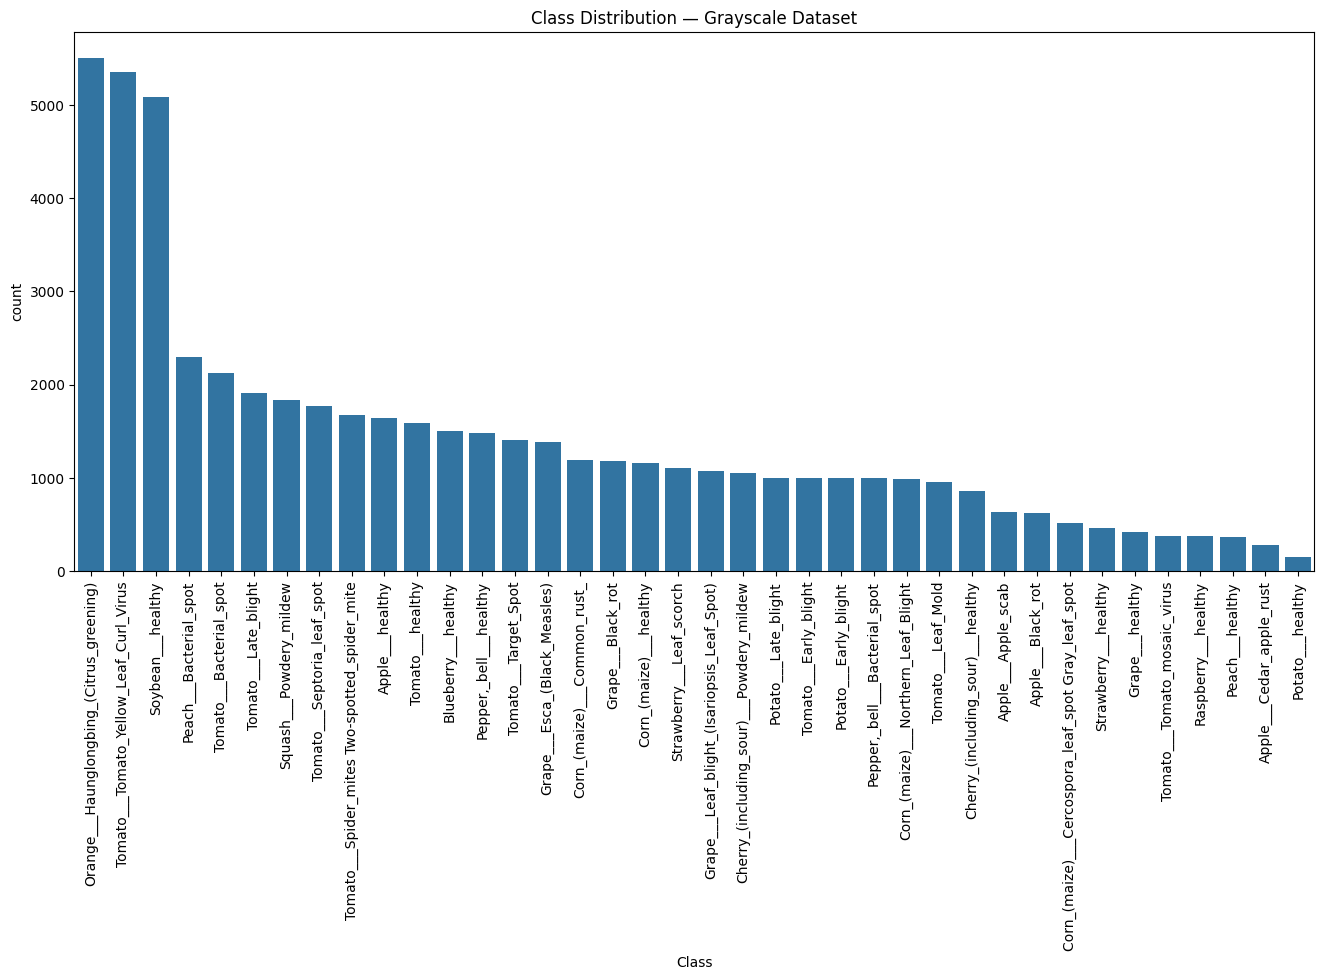

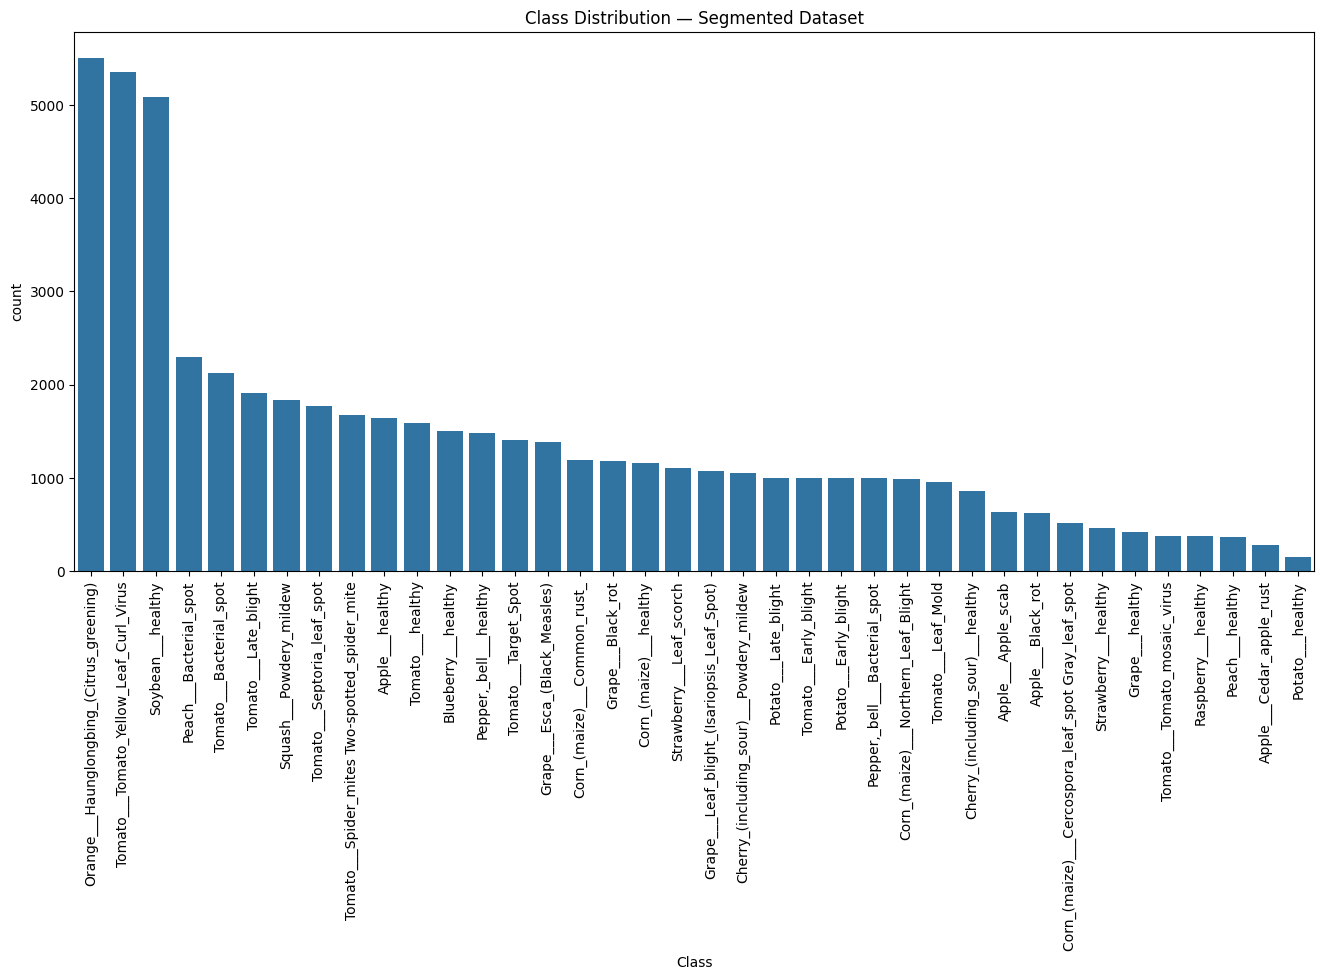

In [5]:
for variant, results in eda_results.items():
    plt.figure(figsize=(16, 7))
    sns.countplot(
        x=results["df"]["Class"],
        order=results["df"]["Class"].value_counts().index
    )
    plt.xticks(rotation=90)
    plt.title(f"Class Distribution — {variant.capitalize()} Dataset")
    plt.show()


# *Resolution Analysis (2D + 3D + Frequency)*
# *2D Scatter - Checks whether images share a common resolution*
# *3D Scatter - Verifies that apparent single-point clustering is not a plotting artifact*
# *Frequency Plot - Quantifies exact resolution percentages*

In [6]:
def extract_image_sizes(df):
    sizes = []

    for p in df["path"]:
        try:
            with Image.open(p) as img:
                w, h = img.size
                sizes.append((h, w))
        except:
            continue

    return pd.DataFrame(sizes, columns=["Height", "Width"])


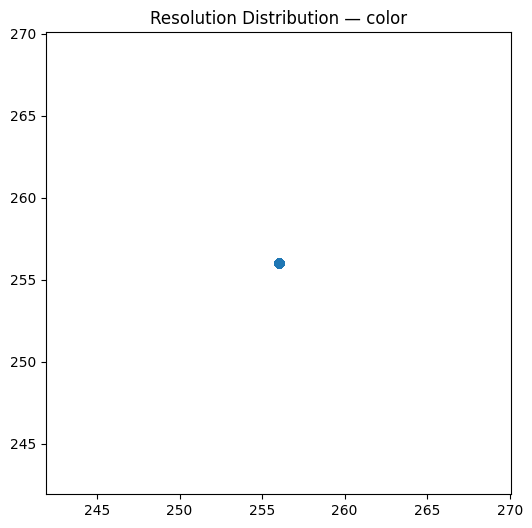

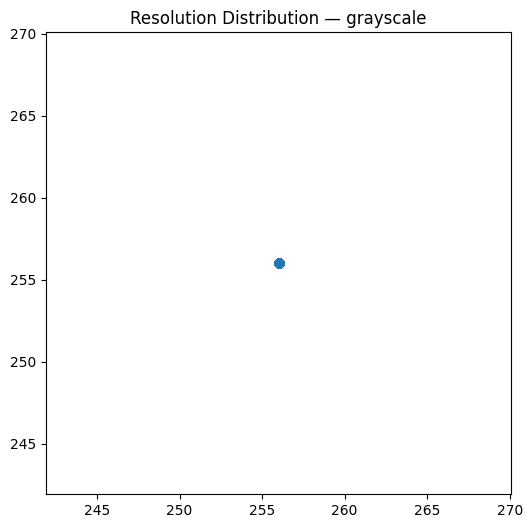

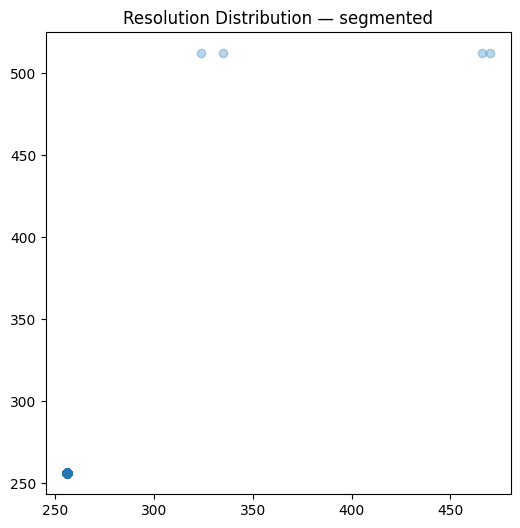

In [7]:
size_distributions = {}

for variant, results in eda_results.items():
    size_df = extract_image_sizes(results["df"])
    size_distributions[variant] = size_df

    # 2D
    plt.figure(figsize=(6, 6))
    plt.scatter(size_df["Width"], size_df["Height"], alpha=0.3)
    plt.title(f"Resolution Distribution — {variant}")
    plt.show()

    # 3D stacked
    size_df["z"] = np.arange(len(size_df))
    fig = px.scatter_3d(
        size_df,
        x="Width",
        y="Height",
        z="z",
        opacity=0.05,
        title=f"3D Resolution Verification — {variant}"
    )
    fig.show()

    # Frequency
    freq = size_df.groupby(["Height", "Width"]).size().reset_index(name="count")
    freq["percentage"] = freq["count"] / freq["count"].sum() * 100

    fig = px.bar(
        freq.sort_values("count", ascending=False),
        y=freq.apply(lambda r: f"{r.Height}×{r.Width}", axis=1),
        x="percentage",
        orientation="h",
        title=f"Resolution Frequency (%) — {variant}"
    )
    fig.show()


# *RGB & HSV Statistics (Color Dataset Only)*
# Color distributions are tightly clustered, indicating controlled acquisition conditions. Some classes show mild brightness clustering, especially within tomato diseases.

In [8]:
def compute_rgb_means(path):
    img = Image.open(path).convert("RGB")
    arr = np.array(img)
    return arr[:,:,0].mean(), arr[:,:,1].mean(), arr[:,:,2].mean()


In [9]:
def compute_hsv_means(path):
    img = cv2.imread(path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return hsv[:,:,0].mean(), hsv[:,:,1].mean(), hsv[:,:,2].mean()


In [10]:
color_df = image_index[image_index["variant"] == "color"]

rgb_records, hsv_records = [], []

for cls in color_df["Class"].unique():
    sample = color_df[color_df["Class"] == cls].sample(30, random_state=RANDOM_SEED)

    for _, row in sample.iterrows():
        try:
            r,g,b = compute_rgb_means(row["path"])
            h,s,v = compute_hsv_means(row["path"])

            rgb_records.append({"Class": cls, "R": r, "G": g, "B": b})
            hsv_records.append({"Class": cls, "H": h, "S": s, "V": v})
        except:
            continue

rgb_df = pd.DataFrame(rgb_records)
hsv_df = pd.DataFrame(hsv_records)


In [11]:
px.box(rgb_df, y=["R","G","B"], title="RGB Channel Distribution").show()
px.box(hsv_df, y=["H","S","V"], title="HSV Channel Distribution").show()
px.box(hsv_df, x="Class", y="V", title="Brightness per Class").update_layout(xaxis_tickangle=90).show()


# *Blur Analysis (Class-Level)*

In [12]:
def blur_score(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(img, cv2.CV_64F).var()


In [13]:
blur_records = []

for cls in color_df["Class"].unique():
    sample = color_df[color_df["Class"] == cls].sample(30, random_state=RANDOM_SEED)

    scores = []
    for p in sample["path"]:
        try:
            scores.append(blur_score(p))
        except:
            continue

    blur_records.append({
        "Class": cls,
        "BlurScore": np.mean(scores)
    })

blur_df = pd.DataFrame(blur_records)
px.box(blur_df, x="Class", y="BlurScore", title="Blur per Class").update_layout(xaxis_tickangle=90).show()


In [14]:
print("Blur classes:", blur_df["Class"].nunique())
print("HSV classes:", hsv_df["Class"].nunique())


Blur classes: 38
HSV classes: 38


# *Blur vs Brightness Correlation*

In [15]:
# ---------- 1. Normalize BLUR to class-level ----------
blur_class_df = (
    blur_df
    .groupby("Class", as_index=False)["BlurScore"]
    .mean()
)

# ---------- 2. Normalize HSV brightness ----------
if "V_mean" in hsv_df.columns:
    hsv_class_df = hsv_df[["Class", "V_mean"]].copy()
elif "V" in hsv_df.columns:
    hsv_class_df = (
        hsv_df
        .groupby("Class", as_index=False)["V"]
        .mean()
        .rename(columns={"V": "V_mean"})
    )
else:
    raise ValueError("HSV dataframe missing brightness column")

merged = pd.merge(
    blur_class_df,
    hsv_class_df,
    on="Class",
    how="inner"
)

merged = merged.sort_values("Class").reset_index(drop=True)
merged["z_stack"] = np.arange(len(merged))

print(f"Classes plotted: {merged['Class'].nunique()}")

fig = px.scatter_3d(
    merged,
    x="V_mean",
    y="BlurScore",
    z="z_stack",
    color="Class",
    hover_name="Class",
    title="Blur vs Brightness vs Class (3D Class-Level EDA)",
    labels={
        "V_mean": "Brightness (HSV Value)",
        "BlurScore": "Blur Score (Laplacian Variance)",
        "z_stack": "Class Index (visual separation)"
    },
    opacity=0.7
)

fig.update_traces(marker=dict(size=5))
fig.show()


Classes plotted: 38


# *Cross-Variant Random Image Comparison*

In [16]:
def visualize_random_triplet(class_name, index_df):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for ax, variant in zip(axes, DATA_VARIANTS.keys()):
        subset = index_df[
            (index_df["Class"] == class_name) &
            (index_df["variant"] == variant)
        ]

        if subset.empty:
            ax.set_title(f"{variant} (missing)")
            ax.axis("off")
            continue

        img_path = subset.sample(1, random_state=RANDOM_SEED)["path"].values[0]
        img = Image.open(img_path)

        ax.imshow(img, cmap="gray" if variant=="grayscale" else None)
        ax.set_title(variant)
        ax.axis("off")

    plt.suptitle(class_name)
    plt.show()


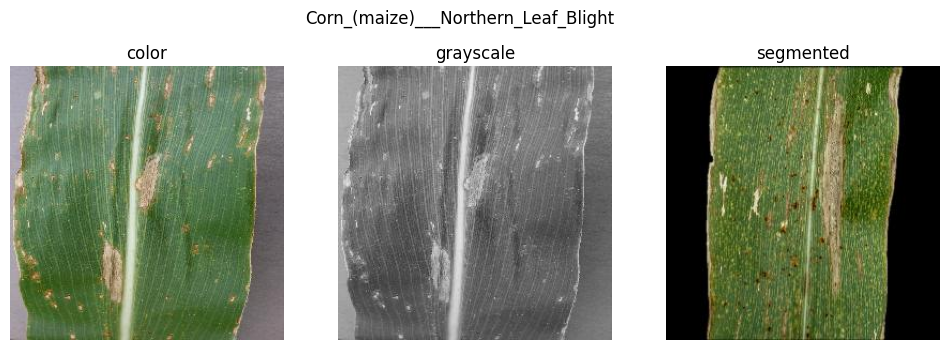

In [17]:
random_class = random.choice(image_index["Class"].unique().tolist())
visualize_random_triplet(random_class, image_index)
